In [1]:
import os
import numpy as np
import pandas as pd
from joblib import dump, load
import sys
import seaborn as sns
import json
sys.path.append(os.path.join(os.path.abspath('../'), 'predictions_collapsed'))
sys.path.append(os.path.join(os.path.abspath('../'), 'src'))
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import torch
import skorch
import glob


from config_loader import (
    D_CONFIG,
    DATASET_SITE_PATH, DATASET_SPLIT_PATH,
    DATASET_FEAT_PER_TSLICE_PATH,
    PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    RESULTS_SPLIT_PATH, RESULTS_FEAT_PER_TSTEP_PATH)

sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src'))
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src', 'rnn'))
from feature_transformation import *
from filter_admissions_by_tslice import get_preprocessed_data
from merge_features_all_tslices import merge_data_dicts, get_all_features_data
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve)
from utils import load_data_dict_json
from dataset_loader import TidySequentialDataCSVLoader
from RNNBinaryClassifier import RNNBinaryClassifier
from sklearn.model_selection import GridSearchCV
RESULTS_FEAT_PER_TSTEP_PATH = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 'rnn')
CLF_TRAIN_TEST_SPLIT_PATH=os.path.join(DATASET_FEAT_PER_TSLICE_PATH, 'classifier_train_test_split')

## Get the labs, vitals and static features from all hospital admissions
- Merge the labs, vitals and demographics into a giant feature dataframe

## Split them into train and test
- Use split_dataset.py

## Read the features into the RNN Binary Classifier 
- Use the dataset_loader.py in time-series-prediction/src/rnn/ to load the data with different time-lengths for rnn train and test

## Train classifier with RNN


In [ ]:
labs_df, labs_data_dict, vitals_df, vitals_data_dict, \
    demographics_df, demographics_data_dict, outcomes_df, outcomes_data_dict = get_preprocessed_data(DATASET_STD_PATH)
features_df,features_data_dict = get_all_features_data(labs_df, labs_data_dict, 
                                                        vitals_df, vitals_data_dict, 
                                                        demographics_df, demographics_data_dict)


feature_cols = parse_feature_cols(features_data_dict)
id_cols = parse_id_cols(features_data_dict)
time_col = parse_time_col(features_data_dict)
## impute values
features_df = features_df.groupby(id_cols).apply(lambda x: x.fillna(method='pad')).copy()
for feature_col in feature_cols:
    features_df[feature_col].fillna(features_df[feature_col].mean(), inplace=True)

# sort by ids and timestamp
features_df.sort_values(by=id_cols+[time_col], inplace=True)
outcomes_df.sort_values(by=id_cols, inplace=True)

x_csv_filename = os.path.join(DATASET_SPLIT_PATH, 'x_train.csv')
x_data_dict_filename = os.path.join(DATASET_SPLIT_PATH, 'x_dict.json')
features_df.to_csv(x_csv_filename, index=False)    

# with open(x_data_dict_filename, 'w') as f:
#     json.dump(features_data_dict, f, indent=4)


y_csv_filename = os.path.join(DATASET_SPLIT_PATH, 'y_train.csv')
y_data_dict_filename = os.path.join(DATASET_SPLIT_PATH, 'y_dict.json')
outcomes_df.to_csv(y_csv_filename, index=False)    

# with open(y_data_dict_filename, 'w') as f:
#     json.dump(outcomes_data_dict, f, indent=4)

In [ ]:
train_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_csv_filename,
    y_csv_path=y_csv_filename,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name='clinical_deterioration_outcome',
    y_label_type='per_sequence'
)

X_train, y_train = train_vitals.get_batch_data(batch_id=0)

In [ ]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
hyperparameters = dict(lr=learning_rate)

# grid search
rnn = RNNBinaryClassifier(
    max_epochs=10,
    batch_size=1024,
    device='cpu',
    lr=0.001,
    callbacks=[
            skorch.callbacks.EpochScoring('roc_auc', lower_is_better=False, on_train=True, name='aucroc_score_train'),
            skorch.callbacks.EpochScoring('roc_auc', lower_is_better=False, on_train=False, name='aucroc_score_valid'),
    ],
    module__rnn_type='LSTM',
    module__n_inputs=X_train.shape[-1],
    module__n_hiddens=32,
    module__n_layers=2,
    optimizer=torch.optim.Adam)

# classifier = GridSearchCV(rnn, hyperparameters, n_jobs=-1, cv=5, verbose=10)
clf = rnn.fit(X_train, y_train)

In [ ]:
features_df

## Evaluate RNN performance

- load the saved RNN models

- Get the test tslice data from all the folders

- Use dataset_loader and impute missing values to first impute and then load the padded sequences

- Test on sequences

In [ ]:
OUTCOME_COLUMN_NAME = 'clinical_deterioration_outcome'
evaluation_tslices = D_CONFIG['EVALUATE_TIMESLICE_LIST']

## get the test patient id's
# get the test set's csv and dict
y_test_df = pd.read_csv(os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.csv'))
y_test_dict_file = os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_dict.json')

# import the y dict to get the id cols
y_test_dict = load_data_dict_json(y_test_dict_file)
id_cols = parse_id_cols(y_test_dict)

tslice_folders = os.path.join(DATASET_FEAT_PER_TSLICE_PATH, 'TSLICE=')
outcome_col_name = OUTCOME_COLUMN_NAME
tslices_list = evaluation_tslices
y_test_ids_df = y_test_df[id_cols].drop_duplicates(subset=id_cols).reset_index(drop=True)

# get demographics csv and data_dict
# for each patient get their vitals, labs, demographics
_,labs_data_dict,_,vitals_data_dict, _, demographics_data_dict,_,_ = get_preprocessed_data(DATASET_SITE_PATH)
time_col = parse_time_col(vitals_data_dict)

# prctile_vals = [5, 50, 95]
# random_seed_list = args.random_seed_list.split(' ')
# perf_df = pd.DataFrame()

# load classifier
rnn = RNNBinaryClassifier(module__rnn_type='LSTM',
                      module__n_layers=1,
                      module__n_hiddens=128,
                      module__n_inputs=X_test.shape[-1])
rnn.initialize()
rnn.load_params(f_params=os.path.join(RESULTS_FEAT_PER_TSTEP_PATH,
                                  'hiddens=128-layers=1-lr=0.0025-dropout=0-weight_decay=0.0001params.pt'),
            f_optimizer=os.path.join(RESULTS_FEAT_PER_TSTEP_PATH,
                                     'hiddens=128-layers=1-lr=0.0025-dropout=0-weight_decay=0.0001optimizer.pt'),
            f_history=os.path.join(RESULTS_FEAT_PER_TSTEP_PATH,
                                   'hiddens=128-layers=1-lr=0.0025-dropout=0-weight_decay=0.0001history.json'))

# predict on each tslice
for p, tslice in enumerate(tslices_list):
    tslice_folder = tslice_folders + tslice
    # get test set labs and vitals
    vitals_df = pd.read_csv(os.path.join(tslice_folder, 'vitals_before_icu_filtered_%s_hours.csv'%tslice))
    labs_df = pd.read_csv(os.path.join(tslice_folder, 'labs_before_icu_filtered_%s_hours.csv'%tslice))
    demographics_df = pd.read_csv(os.path.join(tslice_folder, 'demographics_before_icu_filtered_%s_hours.csv'%tslice))
    outcomes_df = pd.read_csv(os.path.join(tslice_folder,
                                           'clinical_deterioration_outcomes_filtered_%s_hours.csv'%tslice))
    test_vitals_df = pd.merge(vitals_df, y_test_ids_df, on=id_cols)
    test_labs_df = pd.merge(labs_df, y_test_ids_df, on=id_cols)
    test_demographics_df = pd.merge(demographics_df, y_test_ids_df, on=id_cols)

    # merge the labs, vitals and demographics to get a single features table
    test_features_df,test_features_dict = get_all_features_data(test_labs_df, labs_data_dict, 
                                                        test_vitals_df, vitals_data_dict, 
                                                        test_demographics_df, demographics_data_dict)


    test_outcomes_df = pd.merge(outcomes_df, y_test_ids_df, on=id_cols, how='inner')
    
    test_features_df.sort_values(by=id_cols+[time_col], inplace=True)
    test_outcomes_df.sort_values(by=id_cols, inplace=True)
    
    # impute missing values in the test features
    test_features_df = test_features_df.groupby(id_cols).apply(lambda x: x.fillna(method='pad')).copy()
    feature_cols = parse_feature_cols(test_features_dict)
    
    for feature_col in feature_cols:
        test_features_df[feature_col].fillna(test_features_df[feature_col].mean(), inplace=True)    
    
    # load test data with TidySequentialDataLoader
    test_vitals = TidySequentialDataCSVLoader(
        x_csv_path=test_features_df,
        y_csv_path=test_outcomes_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name=outcome_col_name,
        y_label_type='per_sequence'
    )    
    
    # load the classifier
    X_test, y_test = test_vitals.get_batch_data(batch_id=0)
    y_pred_proba = rnn.predict_proba(X_test)
    y_pred_proba_neg, y_pred_proba_pos = zip(*y_pred_proba)
    auroc_test_final = roc_auc_score(y_test, y_pred_proba_pos)
    print('tslice: %s, auroc_test : %.2f'%(tslice, auroc_test_final))
    
    
    
   


## Plot loss curves

In [14]:
rnn_hist_json = os.path.join(RESULTS_FEAT_PER_TSTEP_PATH, 
                         'hiddens=128-layers=2-lr=0.0025-dropout=0-weight_decay=0.0001history.json')

with open(rnn_hist_json, 'r') as f:
    rnn_dict = json.load(f)
epochs=[i['epoch'] for i in rnn_dict[:-1]]
train_loss = [i['train_loss'] for i in rnn_dict[:-1]]
valid_loss = [i['valid_loss'] for i in rnn_dict[:-1]]
aucroc_score_train = [i['aucroc_score_train'] for i in rnn_dict[:-1]]
aucroc_score_valid = [i['aucroc_score_valid'] for i in rnn_dict[:-1]]

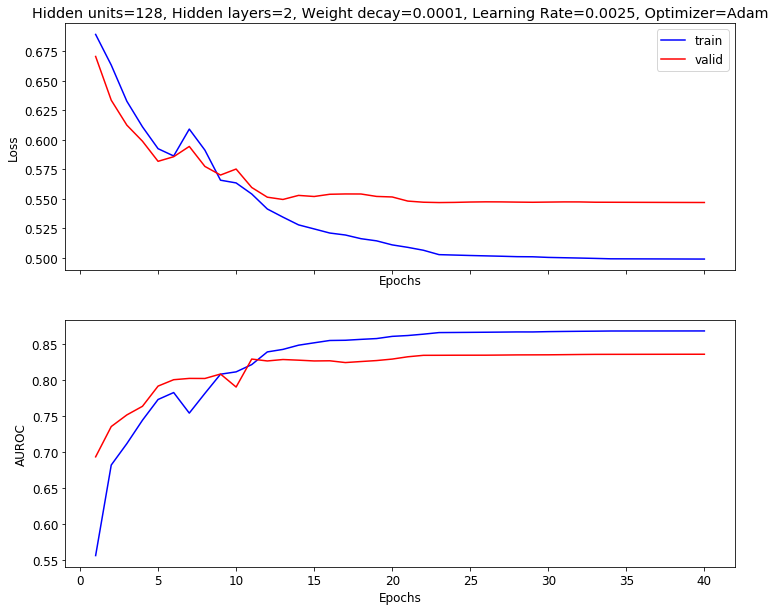

In [27]:
f, axs = plt.subplots(2,1,figsize=(12,10), sharex=True)
plt.rcParams.update({'font.size': 12})
axs[0].plot(epochs, train_loss, 'b', label='train')
axs[0].plot(epochs, valid_loss, 'r', label='valid')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(epochs, aucroc_score_train, 'b')
axs[1].plot(epochs, aucroc_score_valid, 'r')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('AUROC')
axs[0].set_title('Hidden units=128, Hidden layers=2, Weight decay=0.0001, Learning Rate=0.0025, Optimizer=Adam')
plt.show()



In [18]:
plt.rc

<function matplotlib.pyplot.rc(group, **kwargs)>